# Advanced Encapsulation: Model

In [1]:
import mindspore
from mindspore import nn
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset
from mindspore.train import Model, CheckpointConfig, ModelCheckpoint, LossMonitor

In [2]:
def datapipe(path, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = MnistDataset(path)
    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset

# Define model
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

In [3]:
train_dataset = datapipe('MNIST_Data/train', 64)
test_dataset = datapipe('MNIST_Data/test', 64)
model = Network()

# Instantiate loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), 1e-2)

In [9]:
steps_per_epoch = train_dataset.get_dataset_size()
config = CheckpointConfig(save_checkpoint_steps=steps_per_epoch)

ckpt_callback = ModelCheckpoint(prefix="mnist", directory="./checkpoint", config=config)
loss_callback = LossMonitor(steps_per_epoch)

In [10]:
trainer = Model(model, loss_fn=loss_fn, optimizer=optimizer, metrics={'accuracy'})

trainer.fit(10, train_dataset, test_dataset, callbacks=[ckpt_callback, loss_callback])

epoch: 1 step: 938, loss is 0.37135517597198486
Eval result: epoch 1, metrics: {'accuracy': 0.8531}
epoch: 2 step: 938, loss is 0.2966076135635376
Eval result: epoch 2, metrics: {'accuracy': 0.9015}
epoch: 3 step: 938, loss is 0.3660462498664856
Eval result: epoch 3, metrics: {'accuracy': 0.9222}
epoch: 4 step: 938, loss is 0.44235530495643616
Eval result: epoch 4, metrics: {'accuracy': 0.9259}
epoch: 5 step: 938, loss is 0.1428687572479248
Eval result: epoch 5, metrics: {'accuracy': 0.9373}
epoch: 6 step: 938, loss is 0.05964306741952896
Eval result: epoch 6, metrics: {'accuracy': 0.9445}
epoch: 7 step: 938, loss is 0.16607774794101715
Eval result: epoch 7, metrics: {'accuracy': 0.9509}
epoch: 8 step: 938, loss is 0.11525055766105652
Eval result: epoch 8, metrics: {'accuracy': 0.9542}
epoch: 9 step: 938, loss is 0.1342763602733612
Eval result: epoch 9, metrics: {'accuracy': 0.9594}
epoch: 10 step: 938, loss is 0.27597010135650635
Eval result: epoch 10, metrics: {'accuracy': 0.9624}


In [11]:
acc = trainer.eval(test_dataset)
acc

{'accuracy': 0.9624}

## Callback Mechanism

In [3]:
import mindspore
from mindspore import nn
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset
from mindspore.train import Model

In [4]:
def datapipe(path, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = MnistDataset(path)
    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset

# Define model
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

In [5]:
model = Network()
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), 1e-2)

train_dataset = datapipe('MNIST_Data/train', 64)
test_dataset = datapipe('MNIST_Data/test', 64)

trainer = Model(model, loss_fn=loss_fn, optimizer=optimizer, metrics={'accuracy'})

### Common Built-in Callback Functions

In [7]:
from mindspore.train import ModelCheckpoint, CheckpointConfig

# Set the configuration information of the saved model.
config = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
# Instantiate the saved model callback API and define the storage path and prefix.
ckpt_callback = ModelCheckpoint(prefix="mnist", directory="./checkpoint", config=config)

# Start training and load the saved model and parameter callback function.
trainer.train(1, train_dataset, callbacks=[ckpt_callback])

In [8]:
from mindspore.train import LossMonitor

loss_monitor = LossMonitor(300)
# Start training and load the saved model and parameter callback function. The input parameters of LossMonitor are learning rate (0.01) and stride (375).
trainer.train(1, train_dataset, callbacks=[loss_monitor])

epoch: 1 step: 300, loss is 0.5798892974853516
epoch: 1 step: 600, loss is 0.5884872674942017
epoch: 1 step: 900, loss is 0.420920729637146


In [9]:
trainer.fit(1, train_dataset, test_dataset, callbacks=[loss_monitor])

epoch: 1 step: 300, loss is 0.36249208450317383
epoch: 1 step: 600, loss is 0.19838064908981323
epoch: 1 step: 900, loss is 0.2546441853046417
Eval result: epoch 1, metrics: {'accuracy': 0.9188}


In [10]:
import time
import mindspore as ms

class StopTimeMonitor(ms.train.Callback):

    def __init__(self, run_time):
        """Define the initialization process."""
        super(StopTimeMonitor, self).__init__()
        self.run_time = run_time            # Define the execution time.

    def on_train_begin(self, run_context):
        """Operations when training is started."""
        cb_params = run_context.original_args()
        cb_params.init_time = time.time()   # Obtain the current timestamp as the training start time.
        print(f"Begin training, time is: {cb_params.init_time}")

    def on_train_step_end(self, run_context):
        """Operations after each step ends."""
        cb_params = run_context.original_args()
        epoch_num = cb_params.cur_epoch_num  # Obtain the epoch value.
        step_num = cb_params.cur_step_num    # Obtain the step value.
        loss = cb_params.net_outputs         # Obtain the loss value.
        cur_time = time.time()               # Obtain the current timestamp.

        if (cur_time - cb_params.init_time) > self.run_time:
            print(f"End training, time: {cur_time}, epoch: {epoch_num}, step: {step_num}, loss:{loss}")
            run_context.request_stop()       # Stop training.

datasize = train_dataset.get_dataset_size()
trainer.train(5, train_dataset, callbacks=[LossMonitor(datasize), StopTimeMonitor(4)])

Begin training, time is: 1682396722.0708778
End training, time: 1682396726.0770073, epoch: 1, step: 37, loss:0.25167876


In [11]:
import mindspore as ms

# Define the callback API for saving the CKPT file.
class SaveCkptMonitor(ms.train.Callback):
    """Define the initialization process."""

    def __init__(self, loss):
        super(SaveCkptMonitor, self).__init__()
        self.loss = loss # Defines the loss threshold.

    def on_train_step_end(self, run_context):
        """Define the operation to be performed when a step ends."""
        cb_params = run_context.original_args()
        cur_loss = cb_params.net_outputs.asnumpy() # Obtain the current loss value.

        # If the current loss value is less than the preset threshold, the training stops.
        if cur_loss < self.loss:
            # Name the file to be saved.
            file_name = f"./checkpoint/{cb_params.cur_epoch_num}_{cb_params.cur_step_num}.ckpt"
            # Save the network model.
            ms.save_checkpoint(save_obj=cb_params.train_network, ckpt_file_name=file_name)
            print("Saved checkpoint, loss:{:8.7f}, current step num:{:4}.".format(cur_loss, cb_params.cur_step_num))

trainer.train(1, train_dataset, callbacks=[SaveCkptMonitor(0.1), StopTimeMonitor(30)])

Begin training, time is: 1682396726.1809893
Saved checkpoint, loss:0.0790918, current step num: 227.
End training, time: 1682396756.2271755, epoch: 1, step: 326, loss:0.33237484


## Evaluation Metrics

In [12]:
import numpy as np
import mindspore as ms

class MyMAE(ms.train.Metric):
    def __init__(self):
        super(MyMAE, self).__init__()
        self.clear()

    def clear(self):
        """Initialize variables _abs_error_sum and _samples_num."""
        self._abs_error_sum = 0  # Save error sum.
        self._samples_num = 0    # Accumulated data volume.

    def update(self, *inputs):
        """Update _abs_error_sum and _samples_num."""
        y_pred = inputs[0].asnumpy()
        y = inputs[1].asnumpy()

        # Compute the absolute error between the predicted value and the actual value.
        abs_error_sum = np.abs(y - y_pred)
        self._abs_error_sum += abs_error_sum.sum()

        # Total number of samples
        self._samples_num += y.shape[0]

    def eval(self):
        """Compute the final evaluation result."""
        return self._abs_error_sum / self._samples_num

# The network has two outputs.
y_pred = ms.Tensor(np.array([[0.1, 0.2, 0.6, 0.9], [0.1, 0.2, 0.6, 0.9]]), ms.float32)
y = ms.Tensor(np.array([[0.1, 0.25, 0.7, 0.9], [0.1, 0.25, 0.7, 0.9]]), ms.float32)

error = MyMAE()
error.clear()
error.update(y_pred, y)
result = error.eval()
print(result)

0.1499999612569809


In [13]:
import numpy as np
from mindspore import dataset as ds

def get_data(num, w=2.0, b=3.0):
    """Generate data and corresponding labels."""
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 1)
        y = x * w + b + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

def create_dataset(num_data, batch_size=16):
    """Load the dataset."""
    dataset = ds.GeneratorDataset(list(get_data(num_data)), column_names=['data', 'label'])
    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
import mindspore.nn as nn
from mindspore.train import Model, MAE, LossMonitor

net = nn.Dense(1, 1)
loss_fn = nn.L1Loss()
optimizer = nn.Momentum(net.trainable_params(), learning_rate=0.005, momentum=0.9)

# Define a model and use the built-in Accuracy function.
model = Model(net, loss_fn, optimizer, metrics={"MAE": MAE()})

train_dataset = create_dataset(num_data=160)
eval_dataset = create_dataset(num_data=160)
train_dataset_size = train_dataset.get_dataset_size()

model.fit(10, train_dataset, eval_dataset, callbacks=LossMonitor(train_dataset_size))

epoch: 1 step: 10, loss is 4.979913234710693
Eval result: epoch 1, metrics: {'MAE': 5.559346437454224}
epoch: 2 step: 10, loss is 2.832225799560547
Eval result: epoch 2, metrics: {'MAE': 3.12603964805603}
epoch: 3 step: 10, loss is 3.0133275985717773
Eval result: epoch 3, metrics: {'MAE': 2.4620973229408265}
epoch: 4 step: 10, loss is 1.9226611852645874
Eval result: epoch 4, metrics: {'MAE': 2.3035077929496763}
epoch: 5 step: 10, loss is 1.9341741800308228
Eval result: epoch 5, metrics: {'MAE': 1.7947426557540893}
epoch: 6 step: 10, loss is 1.4008338451385498
Eval result: epoch 6, metrics: {'MAE': 1.4339068591594697}
epoch: 7 step: 10, loss is 0.9543579816818237
Eval result: epoch 7, metrics: {'MAE': 1.1794628143310546}
epoch: 8 step: 10, loss is 1.2169930934906006
Eval result: epoch 8, metrics: {'MAE': 1.028759878873825}
epoch: 9 step: 10, loss is 0.7672677040100098
Eval result: epoch 9, metrics: {'MAE': 0.9515393733978271}
epoch: 10 step: 10, loss is 0.7260363101959229
Eval result: e

In [15]:
train_dataset = create_dataset(num_data=160)
eval_dataset = create_dataset(num_data=160)

model = Model(net, loss_fn, optimizer, metrics={"MAE": MyMAE()})

# Define a model and transfer the customized  metrics function MAE to the model.
model.fit(10, train_dataset, eval_dataset, callbacks=LossMonitor(train_dataset_size))

epoch: 1 step: 10, loss is 0.9311931133270264
Eval result: epoch 1, metrics: {'MAE': 0.6712135463953018}
epoch: 2 step: 10, loss is 0.923863410949707
Eval result: epoch 2, metrics: {'MAE': 0.6702738136053086}
epoch: 3 step: 10, loss is 0.9739803671836853
Eval result: epoch 3, metrics: {'MAE': 0.6796592444181442}
epoch: 4 step: 10, loss is 0.6720636487007141
Eval result: epoch 4, metrics: {'MAE': 0.6773041188716888}
epoch: 5 step: 10, loss is 0.8321170806884766
Eval result: epoch 5, metrics: {'MAE': 0.6757591396570206}
epoch: 6 step: 10, loss is 0.7173721790313721
Eval result: epoch 6, metrics: {'MAE': 0.6949960470199585}
epoch: 7 step: 10, loss is 0.7038279175758362
Eval result: epoch 7, metrics: {'MAE': 0.6777522325515747}
epoch: 8 step: 10, loss is 0.9561238288879395
Eval result: epoch 8, metrics: {'MAE': 0.6816858232021332}
epoch: 9 step: 10, loss is 0.9234051704406738
Eval result: epoch 9, metrics: {'MAE': 0.6834914147853851}
epoch: 10 step: 10, loss is 0.6827164888381958
Eval resu

## Model Module Customization

In [16]:
from mindspore import nn

class AlexNet(nn.Cell):
    def __init__(self, num_classes=1000, dropout=0.5):
        super().__init__()
        self.features = nn.SequentialCell(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, pad_mode='pad', padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, pad_mode='pad', padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, pad_mode='pad', padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, pad_mode='pad', padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, pad_mode='pad', padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.SequentialCell(
            nn.Dropout(1-dropout),
            nn.Dense(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(1-dropout),
            nn.Dense(4096, 4096),
            nn.ReLU(),
            nn.Dense(4096, num_classes),
        )

    def construct(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [17]:
import numpy as np
import mindspore
from mindspore import Tensor

x = Tensor(np.random.randn(1, 3, 224, 224), mindspore.float32)

In [18]:
network = AlexNet()
logits = network(x)
print(logits.shape)

(1, 1000)


## Cell and Parameter

In [19]:
import numpy as np
import mindspore
from mindspore import nn
from mindspore import ops
from mindspore import Tensor, Parameter

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = Parameter(Tensor(np.random.randn(5, 3), mindspore.float32), name='w') # weight
        self.b = Parameter(Tensor(np.random.randn(3,), mindspore.float32), name='b') # bias

    def construct(self, x):
        z = ops.matmul(x, self.w) + self.b
        return z

net = Network()

In [20]:
print(net.b.asnumpy())

[-2.0805693  0.3552656 -1.6192602]


In [21]:
print(net.trainable_params())

[Parameter (name=w, shape=(5, 3), dtype=Float32, requires_grad=True), Parameter (name=b, shape=(3,), dtype=Float32, requires_grad=True)]


In [22]:
print(type(net.get_parameters()))

<class 'generator'>


In [23]:
for name, param in net.parameters_and_names():
    print(f"{name}:\n{param.asnumpy()}")

w:
[[ 1.6417935   1.6244147   0.634924  ]
 [ 0.87505287 -0.1105612  -1.4617256 ]
 [ 0.05312686  0.7627763   1.346365  ]
 [-0.26505244 -1.4579067  -0.19795741]
 [ 1.931845   -0.5473185   0.5458011 ]]
b:
[-2.0805693  0.3552656 -1.6192602]


In [24]:
net.b[0] = 1.
print(net.b.asnumpy())

[ 1.         0.3552656 -1.6192602]


In [30]:
net.b.set_data(Tensor([3, 4, 5]))
print(net.b.asnumpy())

[3. 4. 5.]


In [31]:
import mindspore as ms

@ms.jit
def modify_parameter():
    b_hat = ms.Tensor([7, 8, 9])
    ops.assign(net.b, b_hat)
    return True

modify_parameter()
print(net.b.asnumpy())

[7. 8. 9.]


[ERROR] CORE(1336,7f75993af740,python):2023-04-25-11:49:29.957.552 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1336/2418997884.py]
[ERROR] CORE(1336,7f75993af740,python):2023-04-25-11:49:29.960.085 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1336/2418997884.py]
[ERROR] KERNEL(1336,7f75993af740,python):2023-04-25-11:49:30.035.029 [mindspore/ccsrc/plugin/device/cpu/kernel/assign_cpu_kernel.cc:165] LaunchKernel] For 'Assign', memcpy size must be less than or equal to max size, but got memcpy size: 36, and max size: 12


In [33]:
from mindspore.common.initializer import initializer
from mindspore import ParameterTuple
# Creation
x = Parameter(default_input=ms.Tensor(np.arange(2 * 3).reshape((2, 3))), name="x")
y = Parameter(default_input=initializer('ones', [1, 2, 3], ms.float32), name='y')
z = Parameter(default_input=2.0, name='z')
params = ParameterTuple((x, y, z))

# Clone from params and change the name to "params_copy"
params_copy = params.clone("params_copy")

print(params)
print(params_copy)

(Parameter (name=x, shape=(2, 3), dtype=Int64, requires_grad=True), Parameter (name=y, shape=(1, 2, 3), dtype=Float32, requires_grad=True), Parameter (name=z, shape=(), dtype=Float32, requires_grad=True))
(Parameter (name=params_copy.x, shape=(2, 3), dtype=Int64, requires_grad=True), Parameter (name=params_copy.y, shape=(1, 2, 3), dtype=Float32, requires_grad=True), Parameter (name=params_copy.z, shape=(), dtype=Float32, requires_grad=True))


In [34]:
net.set_train()
print(net.phase)

train


In [35]:
net.set_train(False)
print(net.phase)

predict


**Constructing Neural Network Layers by Using the Function Interface**

In [36]:
class Threshold(nn.Cell):
    def __init__(self, threshold, value):
        super().__init__()
        self.threshold = threshold
        self.value = value

    def construct(self, inputs):
        cond = ops.gt(inputs, self.threshold)
        value = ops.fill(inputs.dtype, inputs.shape, self.value)
        return ops.select(cond, inputs, value)

In [37]:
m = Threshold(0.1, 20)
inputs = mindspore.Tensor([0.1, 0.2, 0.3], mindspore.float32)
m(inputs)

Tensor(shape=[3], dtype=Float32, value= [ 2.00000000e+01,  2.00000003e-01,  3.00000012e-01])

**Custom Cell Reverse**

In [38]:
class Dropout2d(nn.Cell):
    def __init__(self, keep_prob):
        super().__init__()
        self.keep_prob = keep_prob
        self.dropout2d = ops.Dropout2D(keep_prob)

    def construct(self, x):
        return self.dropout2d(x)

    def bprop(self, x, out, dout):
        _, mask = out
        dy, _ = dout
        if self.keep_prob != 0:
            dy = dy * (1 / self.keep_prob)
        dy = mask.astype(mindspore.float32) * dy
        return (dy.astype(x.dtype), )

dropout_2d = Dropout2d(0.8)
dropout_2d.bprop_debug = True

## Parameter Initialization

In [43]:
import numpy as np
import mindspore.nn as nn
import mindspore as ms
from mindspore.common.initializer import Normal, initializer

input_data = ms.Tensor(np.ones([1, 3, 16, 50], dtype=np.float32))
# Convolution layer, the input channel is 3, the output channel is 64, the size of convolution kernel is 3 * 3, and the weight parameter uses the random number generated by normal distribution, Nomal().
net = nn.Conv2d(3, 64, 3, weight_init=Normal(0.2))
# The network output
output = net(input_data)
print(output[0, 0, 0])

[ 0.47601968 -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269
 -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269
 -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269
 -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269
 -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269
 -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269
 -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269
 -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269  -0.4681269
 -0.4681269  -0.5583803 ]


In [45]:
import numpy as np
import mindspore.nn as nn
import mindspore as ms

net = nn.Conv2d(3, 64, 3, weight_init='normal')
output = net(input_data)
print(output[0, 0, 0])

[0.04573027 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552
 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552
 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552
 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552
 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552
 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552
 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552
 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552 0.05023552
 0.05023552 0.03975265]


In [47]:
import math
import numpy as np
from mindspore.common.initializer import Initializer, _calculate_fan_in_and_fan_out, _assignment

class XavierNormal(Initializer):
    def __init__(self, gain=1):
        super().__init__()
        # Configure the parameters required for initialization
        self.gain = gain

    def _initialize(self, arr): # arr is a Tensor to be initialized
        fan_in, fan_out = _calculate_fan_in_and_fan_out(arr.shape) # Compute fan_in, fan_out

        std = self.gain * math.sqrt(2.0 / float(fan_in + fan_out)) # Calculate std value
        data = np.random.normal(0, std, arr.shape) # Construct the initialized array with numpy

        _assignment(arr, data) # Assign the initialized ndarray to arr

In [49]:
net = nn.Conv2d(3, 64, 3, weight_init=XavierNormal())
# The network output
output = net(input_data)
print(output[0, 0, 0])

[-0.03786972 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286
 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286
 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286
 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286
 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286
 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286
 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286
 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286 -0.09298286
 -0.09298286 -0.10245635]


In [50]:
for name, param in net.parameters_and_names():
    if 'weight' in name:
        param.set_data(initializer(Normal(), param.shape, param.dtype))
    if 'bias' in name:
        param.set_data(initializer('zeros', param.shape, param.dtype))

In [52]:
for name, param in net.parameters_and_names():
    print(param.asnumpy())

[[[[ 9.93757788e-03  1.07211685e-02  1.43771200e-02]
   [ 1.23295235e-03 -6.91851648e-03  1.05708279e-03]
   [ 1.79048683e-02  1.30180791e-02 -1.18357725e-02]]

  [[-2.77717295e-03 -8.02185666e-03 -1.55472001e-02]
   [-2.27034488e-03  9.95652657e-03 -4.47437214e-03]
   [ 9.35605448e-03 -1.44332983e-02 -2.85325130e-03]]

  [[ 1.73536539e-02  7.40280515e-03  2.96786020e-04]
   [-5.32262074e-03 -1.32603645e-02 -9.17145610e-03]
   [ 5.01711620e-03 -8.96452740e-03  8.54974892e-03]]]


 [[[ 1.05022900e-02 -9.98675171e-03  1.09957065e-02]
   [ 1.61721688e-02 -2.24403862e-04 -2.34854240e-02]
   [-9.90053522e-04  1.12965731e-02  6.38783304e-03]]

  [[-1.06459502e-02  6.19190885e-03 -2.17527268e-03]
   [ 1.04078492e-02 -1.04366876e-02  6.72216713e-03]
   [-3.75546375e-03 -1.51693355e-02 -1.54582318e-02]]

  [[ 2.02229503e-03 -9.26543667e-04  1.11911457e-03]
   [ 7.06475927e-03  1.63003069e-03  4.25465126e-03]
   [-2.54934002e-03 -1.47892628e-02  5.57124673e-04]]]


 [[[ 1.58717576e-02 -2.6210327

## Loss Function

In [53]:
import numpy as np
from mindspore import nn
from mindspore import Tensor

# Output a mean loss value.
loss = nn.L1Loss()
# Output a sum loss value.
loss_sum = nn.L1Loss(reduction='sum')
# Output the original loss value.
loss_none = nn.L1Loss(reduction='none')

input_data = Tensor(np.array([[1, 2, 3], [2, 3, 4]]).astype(np.float32))
target_data = Tensor(np.array([[0, 2, 5], [3, 1, 1]]).astype(np.float32))

print("loss:", loss(input_data, target_data))
print("loss_sum:", loss_sum(input_data, target_data))
print("loss_none:", loss_none(input_data, target_data))

loss: 1.5
loss_sum: 9.0
loss_none: [[1. 0. 2.]
 [1. 2. 3.]]


In [54]:
from mindspore import ops
import mindspore as ms

class MAELoss(nn.Cell):
    """Customize the loss function MAELoss."""
    def construct(self, base, target):
        return ops.abs(base - target).mean()

loss = MAELoss()

input_data = Tensor(np.array([0.1, 0.2, 0.3]).astype(np.float32))  # Generate a predicted value.
target_data = Tensor(np.array([0.1, 0.2, 0.2]).astype(np.float32)) # Generate the actual value.

output = loss(input_data, target_data)
print(output)

0.033333335


In [55]:
class MAELoss(nn.LossBase):
    """Customize the loss function MAELoss."""
    def construct(self, base, target):
        x = ops.abs(base - target)
        return self.get_loss(x)  # Return the mean loss value.

loss = MAELoss()

input_data = Tensor(np.array([0.1, 0.2, 0.3]).astype(np.float32)) # Generate a predicted value.
target_data = Tensor(np.array([0.1, 0.2, 0.2]).astype(np.float32)) # Generate the actual value.

output = loss(input_data, target_data)
print(output)

0.033333335


In [56]:
from mindspore.train import Model, LossMonitor
from mindspore.dataset import GeneratorDataset

def get_data(num, w=2.0, b=3.0):
    """Generate data and corresponding labels."""
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 1)
        y = x * w + b + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

def create_dataset(num_data, batch_size=16):
    """Load the dataset."""
    dataset = GeneratorDataset(list(get_data(num_data)), column_names=['data', 'label'])
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = create_dataset(num_data=160)
network = nn.Dense(1, 1)
loss_fn = MAELoss()
optimizer = nn.Momentum(network.trainable_params(), learning_rate=0.005, momentum=0.9)

# Use the model API to associate the network, loss function, and optimizer.
model = Model(network, loss_fn, optimizer)
model.train(10, train_dataset, callbacks=[LossMonitor(10)])

epoch: 1 step: 10, loss is 4.642879486083984
epoch: 2 step: 10, loss is 3.277451753616333
epoch: 3 step: 10, loss is 2.5152628421783447
epoch: 4 step: 10, loss is 2.0798916816711426
epoch: 5 step: 10, loss is 1.8144643306732178
epoch: 6 step: 10, loss is 1.4661636352539062
epoch: 7 step: 10, loss is 0.9103214740753174
epoch: 8 step: 10, loss is 0.8166921734809875
epoch: 9 step: 10, loss is 0.5158721208572388
epoch: 10 step: 10, loss is 0.9821990132331848


In [57]:
def get_multilabel_data(num, w=2.0, b=3.0):
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise1 = np.random.normal(0, 1)
        noise2 = np.random.normal(-1, 1)
        y1 = x * w + b + noise1
        y2 = x * w + b + noise2
        yield np.array([x]).astype(np.float32), np.array([y1]).astype(np.float32), np.array([y2]).astype(np.float32)

def create_multilabel_dataset(num_data, batch_size=16):
    dataset = GeneratorDataset(list(get_multilabel_data(num_data)), column_names=['data', 'label1', 'label2'])
    dataset = dataset.batch(batch_size) # Each batch has 16 pieces of data.
    return dataset

In [58]:
class MAELossForMultiLabel(nn.LossBase):

    def construct(self, base, target1, target2):
        x1 = ops.abs(base - target1)
        x2 = ops.abs(base - target2)
        return (self.get_loss(x1) + self.get_loss(x2)) / 2

In [59]:
train_dataset = create_multilabel_dataset(num_data=160)

# Define a multi-label loss function.
loss_fn = MAELossForMultiLabel()
# Define the optimizer.
opt = nn.Momentum(network.trainable_params(), learning_rate=0.005, momentum=0.9)

# Define forward function
def forward_fn(data, label1, label2):
    output = network(data)
    return loss_fn(output, label1, label2)

# Get gradient function
grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

# Define function of one-step training
def train_step(data, label1, label2):
    loss, grads = grad_fn(data, label1, label2)
    optimizer(grads)
    return loss

def train(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label1, label2) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label1, label2)

        if batch % 2 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(network, train_dataset)
print("Done!")

Epoch 1
-------------------------------
loss: 0.944074  [  0/ 10]
loss: 0.899381  [  2/ 10]
loss: 0.909936  [  4/ 10]
loss: 0.901096  [  6/ 10]
loss: 0.947869  [  8/ 10]
Epoch 2
-------------------------------
loss: 0.819827  [  0/ 10]
loss: 1.177774  [  2/ 10]
loss: 0.742820  [  4/ 10]
loss: 1.015952  [  6/ 10]
loss: 0.771378  [  8/ 10]
Epoch 3
-------------------------------
loss: 0.874665  [  0/ 10]
loss: 1.229849  [  2/ 10]
loss: 1.042351  [  4/ 10]
loss: 0.794486  [  6/ 10]
loss: 0.668077  [  8/ 10]
Epoch 4
-------------------------------
loss: 0.877751  [  0/ 10]
loss: 0.729632  [  2/ 10]
loss: 0.786010  [  4/ 10]
loss: 0.936999  [  6/ 10]
loss: 0.806662  [  8/ 10]
Epoch 5
-------------------------------
loss: 0.836586  [  0/ 10]
loss: 0.755157  [  2/ 10]
loss: 0.770420  [  4/ 10]
loss: 0.843915  [  6/ 10]
loss: 0.944966  [  8/ 10]
Done!


## Optimizer

In [60]:
import numpy as np
import mindspore
from mindspore import nn, ops
from mindspore import Tensor, Parameter

class Net(nn.Cell):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 6, 5, pad_mode="valid")
        self.param = Parameter(Tensor(np.array([1.0], np.float32)), 'param')

    def construct(self, x):
        x = self.conv(x)
        x = x * self.param
        out = ops.matmul(x, x)
        return out

net = Net()

# Parameters to be updated for the configuration optimizer
optim = nn.Adam(params=net.trainable_params())
print(net.trainable_params())

[Parameter (name=param, shape=(1,), dtype=Float32, requires_grad=True), Parameter (name=conv.weight, shape=(6, 1, 5, 5), dtype=Float32, requires_grad=True)]


In [61]:
conv_params = [param for param in net.get_parameters() if 'conv' in param.name]
for conv_param in conv_params:
    conv_param.requires_grad = False
print(net.trainable_params())
optim = nn.Adam(params=net.trainable_params())

[Parameter (name=param, shape=(1,), dtype=Float32, requires_grad=True)]


In [62]:
# Set the learning rate to 0.01.
optim = nn.Momentum(params=net.trainable_params(), learning_rate=0.01, momentum=0.9)

In [63]:
milestone = [1, 3, 10]
learning_rates = [0.1, 0.05, 0.01]
lr = nn.piecewise_constant_lr(milestone, learning_rates)

# Print the learning rate.
print(lr)

net = Net()
# The optimizer sets the network parameters to be optimized and the piecewise constant learning rate.
optim = nn.SGD(net.trainable_params(), learning_rate=lr)

[0.1, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]


In [65]:
learning_rate = 0.1  # Initial value of the learning rate
decay_rate = 0.9     # Decay rate
decay_steps = 4      #Number of decay steps
step_per_epoch = 2

exponential_decay_lr = nn.ExponentialDecayLR(learning_rate, decay_rate, decay_steps)

for i in range(decay_steps):
    step = Tensor(i, mindspore.int32)
    result = exponential_decay_lr(step)
    print(f"step{i+1}, lr:{result}")

net = Net()

# The optimizer sets the learning rate and computes the learning rate based on the exponential decay function.
optim = nn.Momentum(net.trainable_params(), learning_rate=exponential_decay_lr, momentum=0.9)

step1, lr:0.1
step2, lr:0.097400375
step3, lr:0.094868325
step4, lr:0.09240211


In [66]:
net = Net()
optimizer = nn.Momentum(net.trainable_params(), learning_rate=0.01,
                        momentum=0.9, weight_decay=0.9)

In [67]:
from mindspore.nn import Cell
from mindspore import ops, nn
import mindspore as ms

class ExponentialWeightDecay(Cell):

    def __init__(self, weight_decay, decay_rate, decay_steps):
        super(ExponentialWeightDecay, self).__init__()
        self.weight_decay = weight_decay
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps

    def construct(self, global_step):
        # The `construct` can have only one input. During training, the global step is automatically transferred for computation.
        p = global_step / self.decay_steps
        return self.weight_decay * ops.pow(self.decay_rate, p)

net = Net()

weight_decay = ExponentialWeightDecay(weight_decay=0.0001, decay_rate=0.1, decay_steps=10000)
optimizer = nn.Momentum(net.trainable_params(), learning_rate=0.01,
                        momentum=0.9, weight_decay=weight_decay)

In [68]:
net = Net()

# Convolutional parameter
conv_params = list(filter(lambda x: 'conv' in x.name, net.trainable_params()))
# Non-convolutional parameter
no_conv_params = list(filter(lambda x: 'conv' not in x.name, net.trainable_params()))

# Fixed learning rate
fix_lr = 0.01

# Computation of Learning Rate Based on Polynomial Decay Function
polynomial_decay_lr = nn.PolynomialDecayLR(learning_rate=0.1,      # Initial learning rate
                                           end_learning_rate=0.01, # Final the learning rate
                                           decay_steps=4,          #Number of decay steps
                                           power=0.5)              # Polynomial power

# The convolutional parameter uses a fixed learning rate of 0.001, and the weight decay is 0.01.
# The non-convolutional parameter uses a dynamic learning rate, and the weight decay is 0.0.
group_params = [{'params': conv_params, 'weight_decay': 0.01, 'lr': fix_lr},
                {'params': no_conv_params, 'lr': polynomial_decay_lr}]

optim = nn.Momentum(group_params, learning_rate=0.1, momentum=0.9, weight_decay=0.0)

In [69]:
class Momentum(nn.Optimizer):
    """Define the optimizer."""
    def __init__(self, params, learning_rate, momentum=0.9):
        super(Momentum, self).__init__(learning_rate, params)
        self.momentum = Parameter(Tensor(momentum, ms.float32), name="momentum")
        self.moments = self.parameters.clone(prefix="moments", init="zeros")

    def construct(self, gradients):
        """The input of construct is gradient. Gradients are automatically transferred during training."""
        lr = self.get_lr()
        params = self.parameters # Weight parameter to be updated

        for i in range(len(params)):
            # Update the moments value.
            ops.assign(self.moments[i], self.moments[i] * self.momentum + gradients[i])
            update = params[i] - self.moments[i] * lr # SGD algorithm with momentum
            ops.assign(params[i], update)
        return params

net = Net()
# Set the parameter to be optimized and the learning rate of the optimizer to 0.01.
opt = Momentum(net.trainable_params(), 0.01)

In [70]:
class Momentum(nn.Optimizer):
    """Define the optimizer."""
    def __init__(self, params, learning_rate, momentum=0.9):
        super(Momentum, self).__init__(learning_rate, params)
        self.moments = self.parameters.clone(prefix="moments", init="zeros")
        self.momentum = momentum
        self.opt = ops.ApplyMomentum()

    def construct(self, gradients):
        # Weight parameter to be updated
        params = self.parameters
        success = None
        for param, mom, grad in zip(params, self.moments, gradients):
            success = self.opt(param, mom, self.learning_rate, grad, self.momentum)
        return success

net = Net()
# Set the parameter to be optimized and the learning rate of the optimizer to 0.01.
opt = Momentum(net.trainable_params(), 0.01)

## Data Sampling

In [72]:
from mindspore.dataset import RandomSampler, NumpySlicesDataset

np_data = [1, 2, 3, 4, 5, 6, 7, 8]  # Dataset

# Define a sampler with replacement to sample five pieces of data.
sampler1 = RandomSampler(replacement=True, num_samples=5)
dataset1 = NumpySlicesDataset(np_data, column_names=["data"], sampler=sampler1)

print("With Replacement:    ", end='')
for data in dataset1.create_tuple_iterator(output_numpy=True):
    print(data[0], end=' ')

# Define a sampler without replacement to sample five pieces of data.
sampler2 = RandomSampler(replacement=False, num_samples=5)
dataset2 = NumpySlicesDataset(np_data, column_names=["data"], sampler=sampler2)

print("\nWithout Replacement: ", end='')
for data in dataset2.create_tuple_iterator(output_numpy=True):
    print(data[0], end=' ')

With Replacement:    7 4 8 5 4 
Without Replacement: 5 7 8 6 2 

Image shape: (32, 32, 3) , Label: 6
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 6


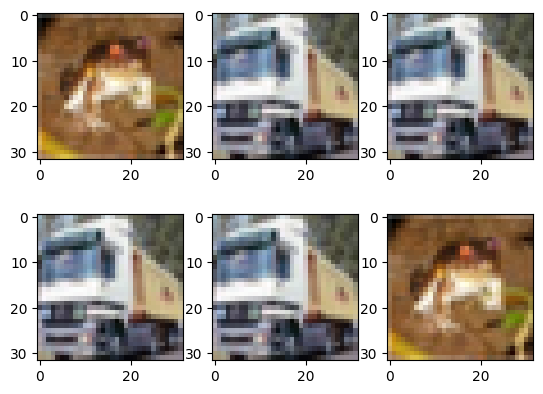

In [73]:
import math
import matplotlib.pyplot as plt
from mindspore.dataset import WeightedRandomSampler, Cifar10Dataset
%matplotlib inline

DATA_DIR = "./cifar-10-batches-bin/"

# Specify the sampling probability of the first 10 samples and sample them.
weights = [0.8, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
sampler = WeightedRandomSampler(weights, num_samples=6)
dataset = Cifar10Dataset(DATA_DIR, sampler=sampler)  # Load data.

def plt_result(dataset, row):
    """Display the sampling result."""
    num = 1
    for data in dataset.create_dict_iterator(output_numpy=True):
        print("Image shape:", data['image'].shape, ", Label:", data['label'])
        plt.subplot(row, math.ceil(dataset.get_dataset_size() / row), num)
        image = data['image']
        plt.imshow(image, interpolation="None")
        num += 1

plt_result(dataset, 2)

Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 4
Image shape: (32, 32, 3) , Label: 1
Image shape: (32, 32, 3) , Label: 9
Image shape: (32, 32, 3) , Label: 6
Image shape: (32, 32, 3) , Label: 1


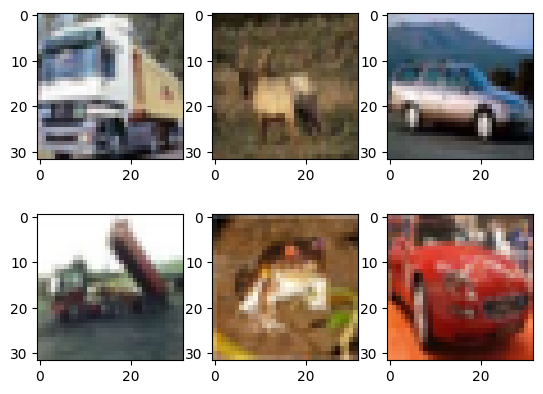

In [74]:
from mindspore.dataset import SubsetRandomSampler

# Specify a sample index subset.
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
sampler = SubsetRandomSampler(indices, num_samples=6)
# Load data.
dataset = Cifar10Dataset(DATA_DIR, sampler=sampler)

plt_result(dataset, 2)

Image shape: (32, 32, 3) , Label: 0
Image shape: (32, 32, 3) , Label: 0
Image shape: (32, 32, 3) , Label: 1
Image shape: (32, 32, 3) , Label: 1
Image shape: (32, 32, 3) , Label: 2
Image shape: (32, 32, 3) , Label: 2
Image shape: (32, 32, 3) , Label: 3
Image shape: (32, 32, 3) , Label: 3
Image shape: (32, 32, 3) , Label: 4
Image shape: (32, 32, 3) , Label: 4


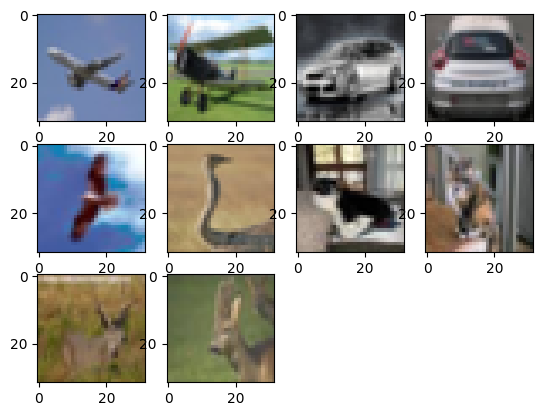

In [75]:
from mindspore.dataset import PKSampler

# 2 samples for each category, up to 10 samples.
sampler = PKSampler(num_val=2, class_column='label', num_samples=10)
dataset = Cifar10Dataset(DATA_DIR, sampler=sampler)

plt_result(dataset, 3)

In [76]:
from mindspore.dataset import DistributedSampler

# Customize the dataset.
data_source = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Divide the constructed dataset into four slices, and sample 3 samples in total.
sampler = DistributedSampler(num_shards=4, shard_id=0, shuffle=False, num_samples=3)
dataset = NumpySlicesDataset(data_source, column_names=["data"], sampler=sampler)

# Print the dataset.
for data in dataset.create_dict_iterator():
    print(data)

{'data': Tensor(shape=[], dtype=Int64, value= 0)}
{'data': Tensor(shape=[], dtype=Int64, value= 4)}
{'data': Tensor(shape=[], dtype=Int64, value= 8)}


In [77]:
import mindspore.dataset as ds

# Customize a sampler.
class MySampler(ds.Sampler):
    def __iter__(self):
        for i in range(0, 10, 2):
            yield i

# Customize a dataset.
np_data = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

# Load data.
dataset = ds.NumpySlicesDataset(np_data, column_names=["data"], sampler=MySampler())
for data in dataset.create_tuple_iterator(output_numpy=True):
    print(data[0], end=' ')

a c e g i 

In [78]:
import mindspore.dataset as ds

class MySampler():
    def __init__(self):
        self.index_ids = [3, 4, 3, 2, 0, 11, 5, 5, 5, 9, 1, 11, 11, 11, 11, 8]
    def __getitem__(self, index):
        return self.index_ids[index]
    def __len__(self):
        return len(self.index_ids)

# Customize a dataset.
np_data = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

# Load data.
dataset = ds.NumpySlicesDataset(np_data, column_names=["data"], sampler=MySampler())
for data in dataset.create_tuple_iterator(output_numpy=True):
    print(data[0], end=' ')

d e d c a l f f f j b l l l l i 

## Converting Dataset to MindRecord

In [79]:
from PIL import Image
from io import BytesIO
from mindspore.mindrecord import FileWriter

file_name = "test_vision.mindrecord"
# Define the contained fields
cv_schema = {"file_name": {"type": "string"},
             "label": {"type": "int32"},
             "data": {"type": "bytes"}}

# Declare the MindSpore Record file format
writer = FileWriter(file_name, shard_num=1, overwrite=True)
writer.add_schema(cv_schema, "it is a cv dataset")
writer.add_index(["file_name", "label"])

# Building a dataset
data = []
for i in range(100):
    sample = {}
    white_io = BytesIO()
    Image.new('RGB', ((i+1)*10, (i+1)*10), (255, 255, 255)).save(white_io, 'JPEG')
    image_bytes = white_io.getvalue()
    sample['file_name'] = str(i+1) + ".jpg"
    sample['label'] = i+1
    sample['data'] = white_io.getvalue()

    data.append(sample)
    if i % 10 == 0:
        writer.write_raw_data(data)
        data = []

if data:
    writer.write_raw_data(data)

writer.commit()

<MSRStatus.SUCCESS: 0>

In [80]:
from mindspore.dataset import MindDataset
from mindspore.dataset.vision import Decode

# Read the MindSpore Record file format
data_set = MindDataset(dataset_files=file_name)
decode_op = Decode()
data_set = data_set.map(operations=decode_op, input_columns=["data"], num_parallel_workers=2)

# Count the number of samples
print("Got {} samples".format(data_set.get_dataset_size()))

Got 100 samples


In [81]:
import numpy as np
from mindspore.mindrecord import FileWriter

# The full path of the output MindSpore Record file
file_name = "test_text.mindrecord"

# Defines the fields that the sample data contains
nlp_schema = {"source_sos_ids": {"type": "int64", "shape": [-1]},
              "source_sos_mask": {"type": "int64", "shape": [-1]},
              "source_eos_ids": {"type": "int64", "shape": [-1]},
              "source_eos_mask": {"type": "int64", "shape": [-1]},
              "target_sos_ids": {"type": "int64", "shape": [-1]},
              "target_sos_mask": {"type": "int64", "shape": [-1]},
              "target_eos_ids": {"type": "int64", "shape": [-1]},
              "target_eos_mask": {"type": "int64", "shape": [-1]}}

# Declare the MindSpore Record file format
writer = FileWriter(file_name, shard_num=1, overwrite=True)
writer.add_schema(nlp_schema, "Preprocessed nlp dataset.")

# Build a virtual dataset
data = []
for i in range(100):
    sample = {"source_sos_ids": np.array([i, i + 1, i + 2, i + 3, i + 4], dtype=np.int64),
              "source_sos_mask": np.array([i * 1, i * 2, i * 3, i * 4, i * 5, i * 6, i * 7], dtype=np.int64),
              "source_eos_ids": np.array([i + 5, i + 6, i + 7, i + 8, i + 9, i + 10], dtype=np.int64),
              "source_eos_mask": np.array([19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=np.int64),
              "target_sos_ids": np.array([28, 29, 30, 31, 32], dtype=np.int64),
              "target_sos_mask": np.array([33, 34, 35, 36, 37, 38], dtype=np.int64),
              "target_eos_ids": np.array([39, 40, 41, 42, 43, 44, 45, 46, 47], dtype=np.int64),
              "target_eos_mask": np.array([48, 49, 50, 51], dtype=np.int64)}
    data.append(sample)

    if i % 10 == 0:
        writer.write_raw_data(data)
        data = []

if data:
    writer.write_raw_data(data)

writer.commit()

<MSRStatus.SUCCESS: 0>

In [82]:
from mindspore.dataset import MindDataset

# Read MindSpore Record file format
data_set = MindDataset(dataset_files=file_name, shuffle=False)

# Count the number of samples
print("Got {} samples".format(data_set.get_dataset_size()))

# Print the part of data
count = 0
for item in data_set.create_dict_iterator(output_numpy=True):
    print("source_sos_ids:", item["source_sos_ids"])
    count += 1
    if count == 10:
        break

Got 100 samples
source_sos_ids: [0 1 2 3 4]
source_sos_ids: [1 2 3 4 5]
source_sos_ids: [2 3 4 5 6]
source_sos_ids: [3 4 5 6 7]
source_sos_ids: [4 5 6 7 8]
source_sos_ids: [5 6 7 8 9]
source_sos_ids: [ 6  7  8  9 10]
source_sos_ids: [ 7  8  9 10 11]
source_sos_ids: [ 8  9 10 11 12]
source_sos_ids: [ 9 10 11 12 13]


In [84]:
from mindspore.dataset import Cifar10Dataset

dataset = Cifar10Dataset("./cifar-10-batches-bin/")  # load data
dataset.save("cifar10.mindrecord")

In [85]:
import os
from mindspore.dataset import MindDataset

# Read MindSpore Record file format
data_set = MindDataset(dataset_files="cifar10.mindrecord")

# Count the number of samples
print("Got {} samples".format(data_set.get_dataset_size()))

if os.path.exists("cifar10.mindrecord") and os.path.exists("cifar10.mindrecord.db"):
    os.remove("cifar10.mindrecord")
    os.remove("cifar10.mindrecord.db")

Got 60000 samples


## Lightweight Data Processing

Image.type: <class 'PIL.Image.Image'>, Image.shape: (356, 200)
Image.type: <class 'PIL.Image.Image'>, Image.shape: (569, 320)
Image.type: <class 'PIL.Image.Image'>, Image.shape: (280, 280)
Image.type: <class 'PIL.Image.Image'>, Image.shape: (360, 360)


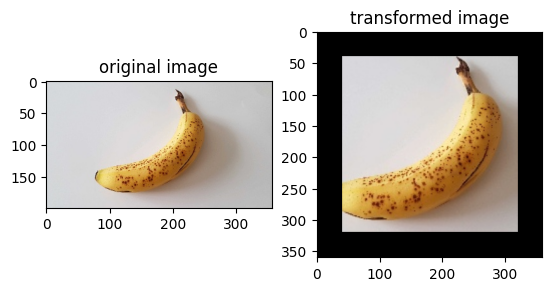

In [87]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import mindspore.dataset.vision as vision

img_ori = Image.open("banana.jpg").convert("RGB")
print("Image.type: {}, Image.shape: {}".format(type(img_ori), img_ori.size))

# Define a Resize op and execute it immediately
op1 = vision.Resize(size=(320))
img = op1(img_ori)
print("Image.type: {}, Image.shape: {}".format(type(img), img.size))

# Define a CenterCrop op and execute it immediately
op2 = vision.CenterCrop((280, 280))
img = op2(img)
print("Image.type: {}, Image.shape: {}".format(type(img), img.size))

# Define a Pad op and execute it immediately
op3 = vision.Pad(40)
img = op3(img)
print("Image.type: {}, Image.shape: {}".format(type(img), img.size))

# Show the result
plt.subplot(1, 2, 1)
plt.imshow(img_ori)
plt.title("original image")
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title("transformed image")
plt.show()

In [88]:
import mindspore.dataset.text.transforms as text
import mindspore as ms

# Define a WhitespaceTokenizer op and execute it immediately
txt = "Welcome to Beijing !"
txt = text.WhitespaceTokenizer()(txt)
print("Tokenize result: {}".format(txt))

# Define a ToNumber op and execute it immediately
txt = ["123456"]
to_number = text.ToNumber(ms.int32)
txt = to_number(txt)
print("ToNumber result: {}, type: {}".format(txt, type(txt[0])))

Tokenize result: ['Welcome' 'to' 'Beijing' '!']
ToNumber result: [123456], type: <class 'numpy.int32'>


In [89]:
import numpy as np
import mindspore.dataset.transforms as trans

# Define a Fill op and execute it immediately
data = np.array([1, 2, 3, 4, 5])
fill = trans.Fill(0)
data = fill(data)
print("Fill result: ", data)

# Define a OneHot op and execute it immediately
label = np.array(2)
onehot = trans.OneHot(num_classes=5)
label = onehot(label)
print("OneHot result: ", label)

Fill result:  [0 0 0 0 0]
OneHot result:  [0 0 1 0 0]


## Graph Data Loading and Processing

In [91]:
from download import download
import os
import shutil

if not os.path.exists("./cora"):
    os.mkdir("./cora")
    if not os.path.exists("./planetoid"):
        url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/planetoid.tar.gz"
        download(url, "./", kind="tar.gz", replace=True)
    content = os.listdir("./planetoid/data")
    new_content = []
    for name in content:
        if "cora" in name:
            new_content.append(name)
    for name in new_content:
        path = "./planetoid/data/"+name
        shutil.copy(path, "./cora")


file_sizes: 100%|███████████████████████████| 12.2M/12.2M [00:17<00:00, 712kB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./


In [92]:
if not os.path.exists("./cora_mindrecord"):
    os.mkdir("./cora_mindrecord")
    url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/graph_to_mindrecord.tar.gz"
    download(url, "./", kind="tar.gz", replace=True)
    os.system('python graph_to_mindrecord/writer.py --mindrecord_script cora --mindrecord_file "./cora_mindrecord/cora_mr" --mindrecord_partitions 1 --mindrecord_header_size_by_bit 18 --mindrecord_page_size_by_bit 20 --graph_api_args "./cora"')


file_sizes: 100%|██████████████████████████| 10.4k/10.4k [00:00<00:00, 1.42MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./
Namespace(graph_api_args='./cora', mindrecord_file='./cora_mindrecord/cora_mr', mindrecord_header_size_by_bit=18, mindrecord_page_size_by_bit=20, mindrecord_partitions=1, mindrecord_script='cora', mindrecord_workers=8, num_edge_tasks=1, num_node_tasks=1)
Init writer  ...
exec task 0, parallel: False ...
Node task is 0
transformed 512 record...
transformed 1024 record...
transformed 1536 record...
transformed 2048 record...
transformed 2560 record...
Processed 2708 lines for nodes.
transformed 2708 record...
exec task 0, parallel: False ...
Edge task is 0
transformed 512 record...
transformed 1024 record...
transformed 1536 record...
transformed 2048 record...
transformed 2560 record...
transformed 3072 record...
transformed 3584 record...
transformed 4096 record...
transformed 4608 record...
transformed 5120 record...
transformed 5632 reco

In [93]:
import mindspore.dataset as ds
import numpy as np

data_file = "./cora_mindrecord/cora_mr"
dataset = ds.GraphData(data_file)

In [94]:
# View the structure information in the graph.
graph = dataset.graph_info()
print("graph info:", graph)

# Obtain information about all nodes.
nodes = dataset.get_all_nodes(0)
nodes_list = nodes.tolist()
print("node shape:", len(nodes_list))

# Obtain the feature and label information. A total of 2708 records are displayed.
# The feature information in each piece of data is a binary representation of 1433 characters used to describe the paper i. The label information refers to the category of the paper.
raw_tensor = dataset.get_node_feature(nodes_list, [1, 2])
features, labels = raw_tensor[0], raw_tensor[1]

print("features shape:", features.shape)
print("labels shape:", labels.shape)
print("labels:", labels)

graph info: {'node_type': [0], 'edge_type': [0], 'node_num': {0: 2708}, 'edge_num': {0: 10858}, 'node_feature_type': [1, 2], 'edge_feature_type': [], 'graph_feature_type': []}
node shape: 2708
features shape: (2708, 1433)
labels shape: (2708,)
labels: [3 4 4 ... 3 3 3]


In [95]:
neighbor = dataset.get_all_neighbors(nodes_list, 0)

# The first column of neighbor is node_id, and the second to last columns store the neighboring nodes in the first column. If there are not so many neighboring nodes, fill them with -1.
print("neighbor:\n", neighbor)

neighbor:
 [[   0  633 1862 ...   -1   -1   -1]
 [   1    2  652 ...   -1   -1   -1]
 [   2 1986  332 ...   -1   -1   -1]
 ...
 [2705  287   -1 ...   -1   -1   -1]
 [2706  165 2707 ...   -1   -1   -1]
 [2707  598  165 ...   -1   -1   -1]]


In [96]:
nodes_num = labels.shape[0]
node_map = {node_id: index for index, node_id in enumerate(nodes_list)}
adj = np.zeros([nodes_num, nodes_num], dtype=np.float32)

for index, value in np.ndenumerate(neighbor):
    # The first column of neighbor is node_id, and the second to last columns store the neighboring nodes in the first column. If there are not so many neighboring nodes, fill them with -1.
    if value >= 0 and index[1] > 0:
        adj[node_map[neighbor[index[0], 0]], node_map[value]] = 1

print("adj:\n", adj)

adj:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


In [97]:
# Multi-hop neighborhood-based node neighbor sampling
neighbor = dataset.get_sampled_neighbors(node_list=nodes_list[0:21], neighbor_nums=[2], neighbor_types=[0])
print("neighbor:\n", neighbor)

# Random walk-based node neighbor sampling
meta_path = [0]
walks = dataset.random_walk(nodes_list[0:21], meta_path)
print("walks:\n", walks)

neighbor:
 [[   0 1862  633]
 [   1  654  652]
 [   2 1454    1]
 [   3 2544 2544]
 [   4 1256 2176]
 [   5 1629 1659]
 [   6 1042 1602]
 [   7  208  208]
 [   8  269  281]
 [   9  723 2614]
 [  10 2545  476]
 [  11 1839 1655]
 [  12 2661 1318]
 [  13 1701 1810]
 [  14 2077 2668]
 [  15 1093 1093]
 [  16 1632 2642]
 [  17  927   24]
 [  18 1560  139]
 [  19 1939 1939]
 [  20 2375 2269]]
walks:
 [[   0 2582]
 [   1  654]
 [   2 1666]
 [   3 2544]
 [   4 1256]
 [   5 1629]
 [   6 1042]
 [   7  208]
 [   8  269]
 [   9  723]
 [  10  476]
 [  11 1839]
 [  12 2662]
 [  13 1701]
 [  14 2668]
 [  15 1090]
 [  16 2642]
 [  17 1316]
 [  18  139]
 [  19 1939]
 [  20 2269]]


In [98]:
# Obtain an edge through a node.
part_edges = dataset.get_all_edges(0)[:10]
nodes = dataset.get_nodes_from_edges(part_edges)
print("part edges:", part_edges)
print("nodes:", nodes)

# Obtain a node through an edge.
nodes_pair_list = [(0, 633), (1, 652), (2, 332), (3, 2544)]
edges = dataset.get_edges_from_nodes(nodes_pair_list)
print("edges:", edges)

part edges: [0 1 2 3 4 5 6 7 8 9]
nodes: [[   0  633]
 [   0 1862]
 [   0 2582]
 [   1    2]
 [   1  652]
 [   1  654]
 [   2 1986]
 [   2  332]
 [   2 1666]
 [   2    1]]
edges: [ 0  4  7 11]


## Advanced Automatic Differentiation

In [99]:
import numpy as np
from mindspore import ops, Tensor
import mindspore.nn as nn
import mindspore as ms

# Define the inputs x and y.
x = Tensor([3.0], dtype=ms.float32)
y = Tensor([5.0], dtype=ms.float32)


class Net(nn.Cell):
    def __init__(self):
        super(Net, self).__init__()
        self.z = ms.Parameter(ms.Tensor(np.array([1.0], np.float32)), name='z')

    def construct(self, x, y):
        out = x * x * y * self.z
        return out

In [100]:
net = Net()
grad_fn = ms.grad(net, grad_position=(0, 1))
gradients = grad_fn(x, y)
print(gradients)

(Tensor(shape=[1], dtype=Float32, value= [ 3.00000000e+01]), Tensor(shape=[1], dtype=Float32, value= [ 9.00000000e+00]))


In [101]:
params = ms.ParameterTuple(net.trainable_params())

output = ms.grad(net, grad_position=None, weights=params)(x, y)
print(output)

(Tensor(shape=[1], dtype=Float32, value= [ 4.50000000e+01]),)


In [102]:
net = nn.Dense(10, 1)
loss_fn = nn.MSELoss()


def forward(inputs, labels):
    logits = net(inputs)
    loss = loss_fn(logits, labels)
    return loss, logits


inputs = Tensor(np.random.randn(16, 10).astype(np.float32))
labels = Tensor(np.random.randn(16, 1).astype(np.float32))
weights = net.trainable_params()

# Aux value does not contribute to the gradient.
grad_fn = ms.grad(forward, grad_position=0, weights=None, has_aux=True)
inputs_gradient, (aux_logits,) = grad_fn(inputs, labels)
print(len(inputs_gradient), aux_logits.shape)

16 (16, 1)


In [103]:
class Net(nn.Cell):

    def __init__(self):
        super(Net, self).__init__()

    def construct(self, x, y):
        out1 = x * y
        out2 = x * y
        out2 = ops.stop_gradient(out2) # Stop computing the gradient of the out2 operator.
        out = out1 + out2
        return out


net = Net()
grad_fn = ms.grad(net)
output = grad_fn(x, y)
print(output)

[5.]


In [104]:
class Net(nn.Cell):
    def __init__(self):
        super(Net, self).__init__()

    def construct(self, x, y):
        out1 = x * y
        out2 = x * y
        # out2 = stop_gradient(out2)
        out = out1 + out2
        return out


net = Net()
grad_fn = ms.grad(net)
output = grad_fn(x, y)
print(output)

[10.]


In [108]:
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore as ms

class Net(nn.Cell):
    """Feedforward network model"""

    def __init__(self):
        super(Net, self).__init__()
        self.sin = ops.Sin()

    def construct(self, x):
        out = self.sin(x)
        return out

x_train = ms.Tensor(np.array([3.1415926]), dtype=ms.float32)

net = Net()
firstgrad = ms.grad(net)
secondgrad = ms.grad(firstgrad)
output = secondgrad(x_train)

# Print the result.
result = np.around(output.asnumpy(), decimals=2)
print(result)

[-0.]


In [109]:
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore as ms

class Net(nn.Cell):
    """Feedforward network model"""
    def __init__(self):
        super(Net, self).__init__()
        self.sin = ops.Sin()
        self.cos = ops.Cos()

    def construct(self, x):
        out1 = self.sin(x)
        out2 = self.cos(x)
        return out1, out2

x_train = ms.Tensor(np.array([3.1415926]), dtype=ms.float32)

net = Net()
firstgrad = ms.grad(net)
secondgrad = ms.grad(firstgrad)
output = secondgrad(x_train)

# Print the result.
result = np.around(output.asnumpy(), decimals=2)
print(result)

[1.]


In [110]:
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore as ms

class Net(nn.Cell):
    """Feedforward network model"""
    def __init__(self):
        super(Net, self).__init__()
        self.sin = ops.Sin()
        self.cos = ops.Cos()

    def construct(self, x, y):
        out1 = self.sin(x) - self.cos(y)
        out2 = self.cos(x) - self.sin(y)
        return out1, out2

x_train = ms.Tensor(np.array([3.1415926]), dtype=ms.float32)
y_train = ms.Tensor(np.array([3.1415926]), dtype=ms.float32)

net = Net()
firstgrad = ms.grad(net, grad_position=(0, 1))
secondgrad = ms.grad(firstgrad, grad_position=(0, 1))
output = secondgrad(x_train, y_train)

# Print the result.
print(np.around(output[0].asnumpy(), decimals=2))
print(np.around(output[1].asnumpy(), decimals=2))

[1.]
[-1.]


## Computational Graph

In [111]:
import mindspore as ms

ms.set_context(mode=ms.PYNATIVE_MODE)

In [112]:
import numpy as np
from mindspore import nn
from mindspore import ops
from mindspore import Tensor, Parameter

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = Parameter(Tensor(np.random.randn(5, 3), ms.float32), name='w') # weight
        self.b = Parameter(Tensor(np.random.randn(3,), ms.float32), name='b') # bias

    def construct(self, x):
        out = ops.matmul(x, self.w)
        print('matmul: ', out)
        out = out + self.b
        print('add bias: ', out)
        return out

model = Network()

In [113]:
x = ops.ones(5, ms.float32)  # input tensor
out = model(x)
print('out: ', out)

matmul:  [-1.0864961  2.102003  -2.9060817]
add bias:  [-2.624806   1.3051174 -2.8831785]
out:  [-2.624806   1.3051174 -2.8831785]


In [114]:
ms.set_context(mode=ms.GRAPH_MODE)

In [115]:
model = Network()

model.compile(x)
out = model(x)
print('out: ', out)

out:  [ 1.5335879  -1.4819053   0.32803032]


[WARNING] ANALYZER(1336,7f75993af740,python):2023-04-25-15:35:57.377.804 [mindspore/ccsrc/pipeline/jit/static_analysis/auto_monad.cc:926] TraceEffectInfo] EffectInfo untraceable: node is a nullptr.


In [116]:
import mindspore as ms
from mindspore import nn

class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.fc = nn.Dense(10, 1)

    @ms.jit
    def construct(self, x):
        return self.fc(x)

In [117]:
@ms.jit
def mul(x, y):
    return x * y

In [118]:
network = nn.Dense(10, 1)
loss_fn = nn.BCELoss()
optimizer = nn.Adam(network.trainable_params(), 0.01)

def forward_fn(data, label):
    logits = network(data)
    loss = loss_fn(logits, label)
    return loss

grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

@ms.jit
def train_step(data, label):
    loss, grads = grad_fn(data, label)
    optimizer(grads)
    return loss

In [119]:
train_step = ms.jit(train_step)